# Next web page prediction

This notebook is comparison of different classifiers for a problem of predicting next web page which user will visit based on the current one. Goal is to use this findings to build a WP plugin for link prefetching using the `rel="prefetch"` attribute.

`PagePaths` class is responsible for managing connection to the Google Analytics API and obtaining data from it. First argument is user's profile ID (ga:XXXXXXX), second is path to the client credentials JSON file and third start date. End date is 'today'. Check this [tutorial](https://developers.google.com/analytics/devguides/config/mgmt/v3/quickstart/installed-py) for more about GA setup. 

`get()` method returns the data directly from the API which can be written to CSV file with `write(data, file_name)`.

`paths` is a list of all web page paths (string) in the dataset. 
`connections` is a list of path indices (from, to) and number of transitions between them for certain date.

In [14]:
import configparser
import numpy as np
from page_paths import PagePaths

config = configparser.ConfigParser()
config.read('config.ini')

pp = PagePaths(config['GA']['viewID'], config['GA']['clientsecret'], '2010-01-01')

paths, connections = pp.get()
pp.write(paths, 'paths.csv')
pp.write(connections, 'connections.csv')

# connections = pp.read('connections.csv')
# paths = pp.read('paths.csv', True)

Split connections to train and test sets (70:30).

In [15]:
from sklearn.model_selection import train_test_split
connections_train, connections_test = train_test_split(connections, test_size=0.3, shuffle=True, random_state=22)

print('# paths(classes): ' + str(len(paths)))
print('# train samples: ' + str(len(connections_train)))
print('# test samples: ' + str(len(connections_test)))

/home/ping/anaconda3/envs/tensorflow3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ping/anaconda3/envs/tensorflow3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ping/anaconda3/envs/tensorflow3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ping/anaconda3/envs/tensorflow3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# paths(classes): 516
# train samples: 12185
# test samples: 5223


Before further usage, we need to split connections to feature (X) and target (y), and one-hot-encode first. X, as being quite sparse, is transformed to compressed sparse row matrix, and y to numpy array.

In [4]:
from sklearn import preprocessing
from scipy.sparse import csr_matrix

def normalize(data):
    X = np.zeros(shape=(len(paths), len(paths)))
    for row in data:
        X[row[0], row[1]] += row[2]
    return preprocessing.normalize(X, norm='l2')

def encode(data):
    X = np.zeros(shape=(len(data), len(paths)))
    y = []
    counter = 0
    for row in data:
        X[counter, row[0]] = row[2]
        y.append(row[1])
        counter += 1
    return csr_matrix(X), np.array(y)

X_train, y_train = encode(connections_train)
X_test, y_test = encode(connections_test)

As we are interested in n >= 1 recommendations, probabilites are predicted for each path in the dataset and then we are extracting top `PREDICTIONS_NUM` for single path. Also, accuracy is calculated for each set of predictions at step `i` and then summed up.

In [53]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

PREDICTIONS_NUM = 10

def get_predictions(classifier, X):
    probabilities = classifier.predict_proba(X)
    predictions = [p.argpartition(-PREDICTIONS_NUM)[-PREDICTIONS_NUM::][::-1] for p in probabilities]
    
    return np.array(predictions)

def get_accuracy(y_true, y_pred, print_at_step=False):
    accuracy = 0
    accuracy_cumulative = []
    
    for i in range(0, PREDICTIONS_NUM):
        accuracy += metrics.accuracy_score(y_true, y_pred[:,i])
        accuracy_cumulative.append(accuracy)
        if print_at_step and i % print_at_step == 0:
            print('Accuracy for set of ' + str(i + 1) + ' prediction/s: ' + str(accuracy))
            print('-' * 50)
    
    return accuracy, accuracy_cumulative

def plot_accuracy(data, title):
    plt.title(title)
    plt.plot(data)
    plt.ylabel('accuracy')
    plt.xlabel('number of predictions')
    plt.xticks(np.arange(PREDICTIONS_NUM + 1, step=2))
    plt.show()


Here we test few classifiers and comparing them considering accuracy and execution time.

K Neighbors
Duration: 0:00:01.809031
Accuracy for set of 1 prediction/s: 0.186608331748
--------------------------------------------------
Accuracy for set of 3 prediction/s: 0.380064675671
--------------------------------------------------
Accuracy for set of 5 prediction/s: 0.54327563249
--------------------------------------------------
Accuracy for set of 7 prediction/s: 0.651322046795
--------------------------------------------------
Accuracy for set of 9 prediction/s: 0.726459958151
--------------------------------------------------


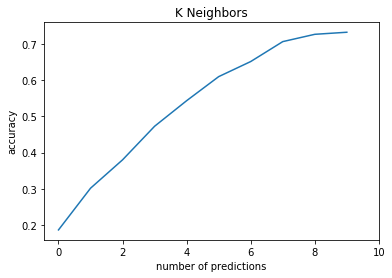

SVC
Duration: 0:03:37.553125
Accuracy for set of 1 prediction/s: 0.201635914019
--------------------------------------------------
Accuracy for set of 3 prediction/s: 0.413734068861
--------------------------------------------------
Accuracy for set of 5 prediction/s: 0.599771732928
--------------------------------------------------
Accuracy for set of 7 prediction/s: 0.731976412403
--------------------------------------------------
Accuracy for set of 9 prediction/s: 0.790755183565
--------------------------------------------------


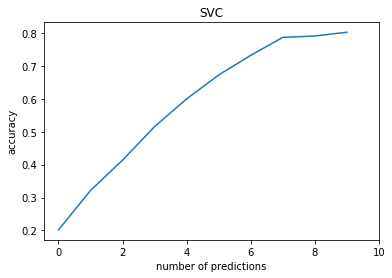

MLP
Duration: 0:00:23.216738
Accuracy for set of 1 prediction/s: 0.187749667111
--------------------------------------------------
Accuracy for set of 3 prediction/s: 0.414114513981
--------------------------------------------------
Accuracy for set of 5 prediction/s: 0.584934373217
--------------------------------------------------
Accuracy for set of 7 prediction/s: 0.716758607571
--------------------------------------------------
Accuracy for set of 9 prediction/s: 0.78847251284
--------------------------------------------------


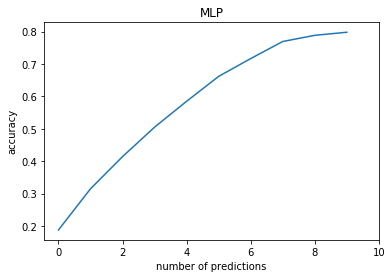

Random Forest
Duration: 0:00:34.629522
Accuracy for set of 1 prediction/s: 0.189271447594
--------------------------------------------------
Accuracy for set of 3 prediction/s: 0.396043370744
--------------------------------------------------
Accuracy for set of 5 prediction/s: 0.576564580559
--------------------------------------------------
Accuracy for set of 7 prediction/s: 0.715427049648
--------------------------------------------------
Accuracy for set of 9 prediction/s: 0.780673387864
--------------------------------------------------


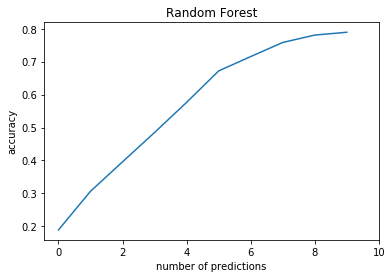

AdaBoost
Duration: 0:00:58.080717
Accuracy for set of 1 prediction/s: 0.205059920107
--------------------------------------------------
Accuracy for set of 3 prediction/s: 0.429712763934
--------------------------------------------------
Accuracy for set of 5 prediction/s: 0.59634772684
--------------------------------------------------
Accuracy for set of 7 prediction/s: 0.709910595397
--------------------------------------------------
Accuracy for set of 9 prediction/s: 0.772493817767
--------------------------------------------------


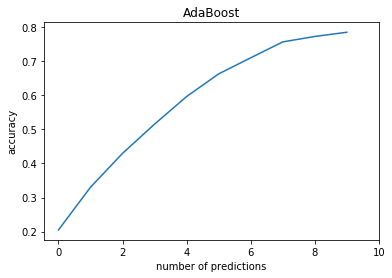

In [54]:
from datetime import datetime

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

RANDOM_SEED = 42

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=len(paths), criterion='gini', random_state=RANDOM_SEED),
    'SVC': SVC(probability=True, kernel='rbf', random_state=RANDOM_SEED),
    'AdaBoost': AdaBoostClassifier(RandomForestClassifier(), random_state=RANDOM_SEED),
    'MLP': MLPClassifier(alpha=0.0006, learning_rate_init=0.009, random_state=RANDOM_SEED),
    'K Neighbors': KNeighborsClassifier(n_neighbors=PREDICTIONS_NUM * 2, algorithm='brute')
}

for name, classifier in classifiers.items():
    start_time = datetime.now()
    classifier.fit(X_train, y_train)
    predictions = get_predictions(classifier, X_test)
    end_time = datetime.now()
    
    print(name)
    print('Duration: ' + str(end_time - start_time))
    
    accuracy, accuracy_cumulative = get_accuracy(y_test, predictions, 2)
    plot_accuracy(accuracy_cumulative, name)

#### Conclusion
All of the displayed models have similar accuracy and they flatten as we approach higher numbers of predictions. AdaBoost and SVC have the best start, ~20% for one and ~59% for five predictions. But SVC with RBF kernel, calculating all the predictions, is also the slowest, and AdaBoost with Random Forest classifier as a base estimator would be a challenge to develop optimally from the scratch with the PHP. 

K-nearest neighbors is definitely weakest of them all but also the fastest. For a lower numbers of predictions, accuracy is solid which is ok because we can't expect more than a few predictions in a real-life scenarios. Therefore, it's a good idea to use it, at least as a fallback model, and with brute-force search and Minkowski distance it is easy to implement.

#### What's next? 
Get more data! Testing these approaches on different datasets would give us a better insight in how they would behave in the production and establish some correlations between model hyperparameters and nature of the data.